In [2]:
# Script for convert lon, lat to tile coords for download link
# GET http(s)://({abcd}.)data.osmbuildings.org/0.2/anonymous/tile/15/{x}/{y}.json
# https://data.osmbuildings.org/0.2/anonymous/tile/15/17605/10743.json

import math

def long_to_x(longitude, zoom):
    return int((longitude + 180.0) / 360.0 * (2.0 ** zoom))

def lat_to_y(latitude, zoom):
    return int((1.0 - math.log(math.tan(math.radians(latitude)) + 1 / math.cos(math.radians(latitude))) / math.pi) / 2.0 * (2.0 ** zoom))

longitude = 13.414041  # Your longitude
latitude = 52.537443  # Your latitude
zoom = 15  # Your zoom level

x = long_to_x(longitude, zoom)
y = lat_to_y(latitude, zoom)
print(x, y)

17604 10743


In [10]:
# Convert GPS coordinates to Cartesian coordinates
import pyproj

def to_cartesian(lat, lon, alt):
    x, y, z = pyproj.Transformer.from_crs(4979, 4978, always_xy=True).transform(lon, lat, alt)
    return x, y, z

to_cartesian(52.537443, 13.414041, 0)

(3781604.2593133603, 901884.5922322688, 5039399.940533286)

In [6]:
# Show geojson map
import folium

# Create a Map instance
m = folium.Map(location=[52.537443, 13.414041], zoom_start=13)

# Load GeoJSON file
folium.GeoJson(
    "export.geojson",
    name='geojson'
).add_to(m)

# Show the map
m


In [65]:
# Script to generate xml file for simulation use in omnet++/inet
# downloaded filename is export.geojson

import json
import math
from xml.etree.ElementTree import Element, SubElement, tostring, ElementTree
from xml.dom import minidom
import pyproj
import numpy as np

# Radius of the Earth in km
R = 6371

# Function to convert lat/lon to metric
def lat_lon_to_metric(lat, lon, min_lat, min_lon):
    x = (lon - min_lon) * math.cos(min_lat) * R * math.pi / 180
    y = (lat - min_lat) * R * math.pi / 180
    return x * 1000, y * 1000  # convert to meters

# # Convert GPS coordinates to Cartesian coordinates
def to_cartesian(lat, lon):
    # Calculate UTM zone from longitude
    zone = int((lon + 180) / 6) + 1
    # Determine if the point is in the Northern or Southern hemisphere
    hemisphere = 'north' if lat >= 0 else 'south'

    # define the coordinate systems
    transformer = pyproj.Transformer.from_crs("epsg:4326", f"epsg:326{zone if lat >= 0 else zone + 100}")

    x, y = transformer.transform(lat, lon)
    return x, y

# Helper function to extract all points in the geojson
def get_points(geometry):
    if geometry['type'] == 'Polygon':
        return geometry['coordinates'][0]
    elif geometry['type'] == 'MultiPolygon':
        return [pt for polygon in geometry['coordinates'] for pt in polygon[0]]

# Parse the GeoJSON
with open("export.geojson") as f:
    geojson = json.load(f)

# Get the minimum latitude and longitude
min_lat = 10**5
for feat in geojson["features"]:
    for p in get_points(feat["geometry"]):
        min_lat = min(min_lat, p[1])
min_lon = 10**5
for feat in geojson["features"]:
    for p in get_points(feat["geometry"]):
        min_lon = min(min_lon, p[0])

min_x, min_y = to_cartesian(min_lat, min_lon)

# Create the root element
root = Element('environment')

# Prepare node locations
node_locations = []
polygon_position = [] # for analysis

# Loop through the features
for feature in geojson['features']:
    # Only process polygons
    if feature['geometry']['type'] in ('Polygon', 'MultiPolygon'):
        # Create the object element
        obj = SubElement(root, 'object')
        
        # Set object attributes
        height = feature['properties'].get('height', 10)  # Use height from properties or default to 10
        
        # Convert the coordinates to metric and generate the shape attribute
        shape_coords = []
        metric_coords = []
        for coords in get_points(feature['geometry']):
            x, y = lat_lon_to_metric(coords[1], coords[0], min_lat, min_lon)
            # x, y = to_cartesian(coords[1], coords[0])
            # x, y = x-min_x, y-min_y
            metric_coords.append([x, y])
            shape_coords.append(f"{x} {y} ")

        min_metric_coords = np.min(metric_coords, axis=0)
        obj.set('position', f"min {min_metric_coords[0]} {min_metric_coords[1]} 0")

        node_locations.append(list(min_metric_coords)+[height+1])
        for c in metric_coords:
            polygon_position.append(c)

        shape = f"prism {height} " + ' '.join(shape_coords)
        obj.set('shape', shape)
        
        obj.set('material', "brick")
        obj.set('fill-color', "203 65 84")
        obj.set('opacity', "0.8")

# Generate the XML string
xml_string = tostring(root)

# Pretty print the XML
xml_pretty = minidom.parseString(xml_string).toprettyxml(indent="   ")

# Write XML string to file
with open('buildings.xml', 'w') as f:
    f.write(xml_pretty)
    
#print(xml_pretty)
print(node_locations)


[[-80.81919192821616, 163.6789320207566, 8.8], [-181.68211613256125, 176.24395873147162, 19], [-125.4880810010191, 176.46634858498933, 10], [-169.22636821807242, 264.4215355607843, 19], [-110.74162082632137, 298.66957296775007, 29.2], [-103.5831450133909, 346.37219649792155, 16.3], [-94.13395694025154, 381.62098824453193, 25.3], [-74.80607224526301, 453.3417159301249, 8.5], [-83.61099749521071, 713.9826239850584, 16], [-89.98204096879763, 742.0037454990586, 16], [-136.6553032691245, 567.7612954476662, 23], [-77.23995402175092, 442.3334181924538, 13.7], [-576.6152267329333, 27.465146881390876, 19], [-499.94795077617107, 61.157209654957335, 23], [-542.3977123469682, 61.04601472780343, 19], [-578.9059389930152, 63.82588789400968, 19], [-582.6999311738352, 82.50663557053645, 19], [-507.8222741704963, 92.84776374844446, 23], [-587.20977093605, 97.85153544745769, 21.1], [-565.233250190346, 107.19190928572107, 19], [-518.6315726479679, 107.97027377184799, 23], [-585.7064910153118, 113.9747998

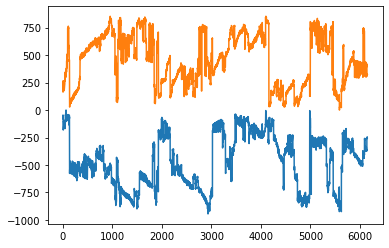

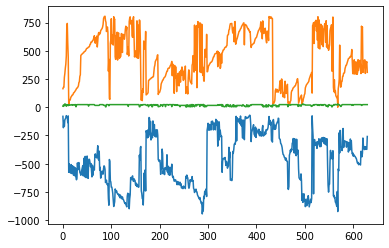

array([-466.41846678,  453.55136526])

In [66]:
# Print node locations
import matplotlib.pyplot as plt
plt.plot(polygon_position)
plt.show()
plt.plot(node_locations)
plt.show()

np.mean(polygon_position, axis=0)

In [79]:
import random
import math

with open('node_locations_gw100m.txt', 'w') as f:
    random.seed(10)
    node_num = 10
    gw_x = -466
    gw_y = 453
    gw_z = 100
    f.write("**.loRaGW[0].**.initialX = " + str(gw_x) + "m\n")
    f.write("**.loRaGW[0].**.initialY = " + str(gw_y) + "m\n")
    f.write("**.loRaGW[0].**.initialZ = " + str(gw_z) + "m\n")
    locations = []
    distances = []
    for i in range(node_num):
        index = random.randrange(0,len(node_locations))
        x, y, z = node_locations[index]
        locations.append([x,y,z])
        distances.append(math.sqrt((gw_x-x)**2 + (gw_y-y)**2 + (gw_z-z)**2))
        f.write("**.loRaNodes[" + str(i) + "].**.initialX = " + str(x) + "m\n")
        f.write("**.loRaNodes[" + str(i) + "].**.initialY = " + str(y) + "m\n")
        f.write("**.loRaNodes[" + str(i) + "].**.initialZ = " + str(z) + "m\n")
    f.write(str(locations)+"\n")
    f.write(str(distances)+"\n")

